# Spark Machine Learning

Environment: Python 3.7, Jupyter notebook, JDK1.8, Ubuntu

Libraries used:
* pyspark (provided in Anaconda 3)
* matplotlib (for plot graphs, provided in Anaconda 3)
* numpy(for array, provided in Anaconda 3)

## Introduction
In this project, it is aimed to predict rain condition in the next day. With the dataset `weather.csv` provided, the program should follow the steps below,

1. import Spark Session and intialize Spark
2. load the dataset and print the schema and total number of entries
3. delete columns from the dataset
4. print the number of missing data in each column
5. fill the missing data with average value and maximum occurrence value
6. data transformation  
7. create the feature vector and divide the dataset  
8. apply machine learning classification algorithms on the dataset and compare their accuracy, then plot the accuracy as bar graph.   
9. calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved.

## A. Creating Spark Session and Loading the Data
### Step 01: Import Spark Session and initialize Spark

In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import pyspark.sql.types as types
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# If there is no existing spark context, we now create a new context by SparkConf
if (sc is None):
    conf = pyspark.SparkConf()
    conf.set("spark.app.name", "Machine Learning by Spark")
    conf.set("spark.master", "local[*]")
    sc = SparkContext(conf=conf)

spark = SparkSession(sparkContext=sc) \
    .builder \
    .appName("SparkSQL") \
    .getOrCreate()

### Step 02: Load the dataset and print the schema and total number of entries

In [5]:
# read the data from csv file into DataFrame
data = spark.read.csv("weather.csv", header=True, inferSchema=True)
# display the schema
data.printSchema()
# display the number of rows in the DataFrame
print(f"The number of records in the data frame is {data.count()}.")

root
 |-- Date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)

The number of records in the data frame

## B. Data Cleaning and Processing

### Step 03: Delete columns from the dataset

The columns below should be deleted, 
- Date
- Location
- Evaporation
- Sunshine
- Cloud9am
- Cloud3pm
- Temp9am
- Temp3pm


In [6]:
# define a set contains all columns should be deleted
uselessColumns = {"Date", 
                  "Location", 
                  "Evaporation", 
                  "Sunshine",
                  "Cloud9am",
                  "Cloud3pm",
                  "Temp9am",
                  "Temp3pm"}

# select the columns not in uselessColumns set
newColumns = [column for column in data.columns if column not in uselessColumns]
data = data.select(newColumns)
# use cache to boost the process
data.cache()
data.show(15)
data.printSchema()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

### Step 04: Print the number of missing data in each column.

By examining the data frame in the output of step 03, the missing data is represented as a string "NA". Therefore, to count the missing data in each column, the amount of string "NA" should be calculated.

In [7]:
# define a function for count the NA for each column
def countNAForColumn(values):
    values = [each[0] for each in values]
    return values.count("NA")

def countNA(dataFrame):
    # display the result
    dataFrame.select([f.count(f.when(dataFrame[c] == "NA", c)).alias(c) for c in dataFrame.columns]).show()
    return

countNA(data)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|    637|    322|    1406|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



### Step 05: Fill the missing data with average value and maximum occurrence value.

In [8]:
data.show(2)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+----

From the output, the columns can be devided to 3 types:
 - Numeric column: the values are numeric, and NA values should be filled with the average value in the column
 - Categorical column: the values are not numeric, and NA values should be filled with the maximum occurrence value
 - Label column: the "RainTomorrow" column should not be changed

Therefore, build 2 sets to store the column names to classify the column types.

In [9]:
numericCol = {"MinTemp", "MaxTemp", "Rainfall", "Wind", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", 
              "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm"}
categoricalCol = {"WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"}

In [10]:
# the function is to calculate the average value in the column
def calculateAvg(dataFrame, columnName: str) -> str:
    mean = dataFrame.filter(f.col(columnName) != "NA") \
        .select(f.mean(f.col(columnName))) \
        .collect()[0][0]
    return str(round(mean, 1))

# the function is to get maximum occurrence value in the column 
def getMode(dataFrame, columnName: str) -> str:
    dataCountDf = dataFrame.select(columnName) \
        .groupBy(columnName) \
        .count() \
        .orderBy("count") \
        .collect()
    mode = dataCountDf[-1][0]
    return mode

# the function is to fill the missing value for a given column
def fixMissingValues(dataFrame, columnName: str) -> str:
    # classify the column to get correct value for replace
    if columnName in numericCol:
        replaceValue = calculateAvg(dataFrame, columnName)
    elif columnName in categoricalCol:
        replaceValue = getMode(dataFrame, columnName)
        
    # define a UDF for manipulating each value in a column
    def replaceMissingValue(string: str) -> str:
        if string == "NA":
            return replaceValue
        else:
            return string
    replaceUDF = f.udf(replaceMissingValue, types.StringType())
    
    # apply the UDF to fix the missing values
    dataFrame = dataFrame.withColumn(columnName, replaceUDF(dataFrame[columnName]))
    return dataFrame

In [11]:
# apply the function in previous
for columnName in data.columns:
    data = fixMissingValues(data, columnName)

data.cache()
# count the missing values again and display
countNA(data)
print()

21/10/29 03:35:46 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.
[Stage 48:===========================================>              (3 + 1) / 4]

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|      0|      0|       0|          0|            0|         0|         0|           0|           0|          0|          0|          0|          0|        0|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+




From the output, it is clearly that all missing data has been fixed.

### Step 06: Data transformation  

In [12]:
data.printSchema()

root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



According to the output of `printSchema()` method, all data inside are string. The next step is to transform the data for machine to calculate. As there are 3 different types of columns; therefore, using 3 different methods to transform these 3 different types,
 - Numeric column: Cast to `double` type
 - Categorical column: Use `StringIndexer`, then `OneHotEncoderEstimator` to transform
 - Label column: Only use `StringIndexer` to transform
 
Then, drop the original columns and rename the new columns for better readability.

In [13]:
for columnName in data.columns:
    # for numeric columns
    if columnName in numericCol:
        data = data.withColumn(columnName, f.col(columnName).cast("double"))
    
    # for categorical columns
    elif columnName in categoricalCol:
        # apply the StringIndexer and OneHotEncoderEstimator to transform
        pipeline = Pipeline(stages=[
            StringIndexer(inputCol=columnName, outputCol=columnName+"Index"),
            OneHotEncoderEstimator(inputCols=[columnName+"Index"], outputCols=[columnName+"ClassVec"])
        ])
        data = pipeline.fit(data).transform(data)
        # drop original categorical column and rename the new one
        data = data.drop(columnName, columnName+"Index") \
            .withColumnRenamed(columnName+"ClassVec", columnName)
    
    # for label column
    else:
        # apply the StringIndexer to transform
        # drop the original column
        data = StringIndexer(inputCol=columnName, outputCol=columnName+"Index") \
            .fit(data) \
            .transform(data) \
            .drop(columnName) \
            .withColumnRenamed(columnName+"Index", "label")
data.cache()
data.show(2)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+--------------+--------------+--------------+-------------+-----+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|   WindGustDir|    WindDir9am|    WindDir3pm|    RainToday|label|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+--------------+--------------+--------------+-------------+-----+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|(15,[0],[1.0])|(15,[6],[1.0])|(15,[7],[1.0])|(1,[0],[1.0])|  0.0|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|(15,[9],[1.0])|(15,[9],[1.0])|(15,[3],[1.0])|(1,[0],[1.0])|  0.0|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+----------

In [14]:
data.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- WindGustDir: vector (nullable = true)
 |-- WindDir9am: vector (nullable = true)
 |-- WindDir3pm: vector (nullable = true)
 |-- RainToday: vector (nullable = true)
 |-- label: double (nullable = false)



From the output, all the numeric columns has been transformed to double type, and the categorical columns has been transformed to vectors containing numeric values.

### Step 07: Create the feature vector and divide the dataset

Assemble the feature vector by `VectorAssembler`.

In [15]:
# RainTomorrow should be excluded
assemblerInputs = [column for column in data.columns if column != "label"]
data = VectorAssembler(inputCols = assemblerInputs, outputCol="features") \
    .transform(data)
data.show(1)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+--------------+--------------+--------------+-------------+-----+--------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|   WindGustDir|    WindDir9am|    WindDir3pm|    RainToday|label|            features|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+--------------+--------------+--------------+-------------+-----+--------------------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|(15,[0],[1.0])|(15,[6],[1.0])|(15,[7],[1.0])|(1,[0],[1.0])|  0.0|(56,[0,1,2,3,4,5,...|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+--------------+--------------+--------------+-------------+-----+-----------------

Then, divide the data randomly with 70% and 30% as training data and test data.

In [16]:
trainingData, testData = data.randomSplit([0.7, 0.3])
# cache these data frame to boost the model training
trainingData.cache()
testData.cache()
print()

## C. Apply Machine Learning Algorithms
### Step 08: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph.

From the specifications, there are 4 classification algorithms should be implemented. These are, 
 - DecisionTreeClassifier
 - RandomForestClassifier
 - LogisticRegression
 - GBTClassifier

Implement the 4 classifiers below and calculate the accuracy.

In [17]:
# define a function to apply the machine learning classification algorithm
def applyMLAlgorithms(classfier):
    # train the model with trainingData and generate the prediction in testData
    model = classfier.fit(trainingData)
    predictions = model.transform(testData) \
        .select("prediction", "label")
    # evaluate the accuracy
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction", metricName="accuracy"
    )
    accuracy = evaluator.evaluate(predictions)
    
    # define a inner class to wrap the result
    class MLResult:
        def __init__(self, accuracy, predictionAndLabelsDF, classfierName):
            self.accuracy = accuracy
            self.predictionAndLabelsDF = predictionAndLabelsDF
            self.classfierName = classfierName
    return MLResult(accuracy, predictions, type(classfier).__name__)

# build the list containing these 4 algorithms
classifierList = [DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier]
# initialize the classifiers with parameter labelCol and featuresCol
defaultClassifiers = list(map(lambda x: x(labelCol="label", featuresCol="features"), classifierList))
# apply the funciton to generate the machine learning results
predictionResults = list(map(applyMLAlgorithms, defaultClassifiers))
# extract the accuracy value from the results
acc = [each.accuracy for each in predictionResults]

21/10/29 03:36:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/10/29 03:36:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
21/10/29 03:36:15 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
21/10/29 03:36:15 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed


In [18]:
# display the accuracy for each algorithm
[print(f"{type(cla).__name__}\'s accuracy is {ac}") for cla, ac in zip(defaultClassifiers, acc)]
print()

DecisionTreeClassifier's accuracy is 0.8336627140974967
RandomForestClassifier's accuracy is 0.8176642198381329
LogisticRegression's accuracy is 0.8398033126293996
GBTClassifier's accuracy is 0.8426030491247882



Then, using `matplotlib` to plot a bar chart for the accuracies of 4 algorithms.

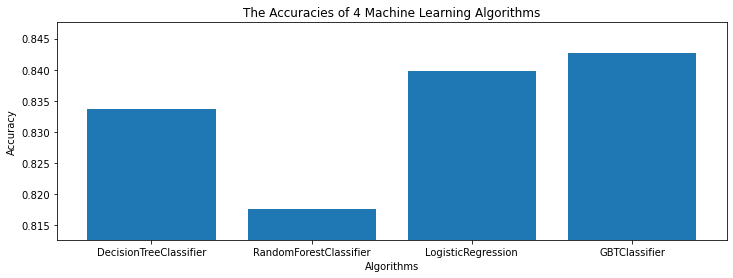

In [19]:
# plot
xTicks = [type(each).__name__ for each in defaultClassifiers]
plt.figure(figsize=(12,4))
plt.bar(range(4), acc)
plt.xticks(range(4), xTicks)
# set the y-axis limit for better readability
plt.ylim(min(acc)-0.005, max(acc)+0.005)
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")
plt.title("The Accuracies of 4 Machine Learning Algorithms")
plt.show()

### Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved?  

Then, use the `MulticlassMetrics` to calculate the confusion matrix for each algorithm.

The confusion matrix is the matrix like below,

|Predict| Actual True | Acual False |
|-------| ------------|-------------|
|True   |True Positive (TP)|False Positive (FP)|
|False  |False Negative (FN)| True Negative (TN)|

Confusion matrix: $$confusionMatrix = \left[
\begin{matrix}
TP & FP \\
FN & TN
\end{matrix}
\right] \tag{2}
 $$

Besides, the other value related to the confusion matrix is defined below,

Accuracy: $$ accuracy = \frac{TP+TN}{TP+FP+FN+TN}$$
Precision: $$ precision = \frac{TP}{TP+FP}$$
Recall: $$ recall = \frac{TP}{TP+FN}$$
F1 score: $$ F_1 = 2*\frac{precision \times recall}{precision + recall}$$

Apply these method into the the data.

In [20]:
# the function is for generating MulticlassMetrics object for each algorithm
def getConfusionMatrix(predictionAndLabelsDF):
    toRdd = lambda df: df.rdd.map(lambda x: (x.prediction, x.label))
    metrics = MulticlassMetrics(predictionAndLabels=toRdd(predictionAndLabelsDF))
    return metrics

# the function is to display the information of confusion matrix
def displayConfusionMatrixInfo(mlResult):
    metrics =  getConfusionMatrix(mlResult.predictionAndLabelsDF)
    # generate confusion matrix with default method
    confusionMatrix = metrics.confusionMatrix().toArray()
    (tn, fp), (fn, tp) = confusionMatrix
    # reformat the confusion matrix to the correct one
    confusionMatrix = np.array([[tp, fp],
                                [fn, tn]])
    # collect other information required
    accuracy = metrics.accuracy
    precision = metrics.precision(label=1.0)
    recall = metrics.recall(label=1.0)
    f1 = metrics.fMeasure(label=1.0, beta=1.0)
    # return the string for display
    return f"""The infomation of confusion matrix of {mlResult.classfierName} is:
ConfusionMatrix: 
{confusionMatrix}
Precision: {precision}
Recall: {recall}
F1 Score: {f1}
"""

In [21]:
# apply the function in previous to display
displayInfoList = list(map(displayConfusionMatrixInfo, predictionResults))
for each in displayInfoList:
    print(each)

The infomation of confusion matrix of DecisionTreeClassifier is:
ConfusionMatrix: 
[[ 3656.  1234.]
 [ 5836. 31778.]]
Precision: 0.7476482617586913
Recall: 0.38516645596291615
F1 Score: 0.5084132943957725

The infomation of confusion matrix of RandomForestClassifier is:
ConfusionMatrix: 
[[ 2187.   445.]
 [ 7305. 32567.]]
Precision: 0.8309270516717325
Recall: 0.2304045512010114
F1 Score: 0.36077202243483997

The infomation of confusion matrix of LogisticRegression is:
ConfusionMatrix: 
[[ 4459.  1776.]
 [ 5033. 31236.]]
Precision: 0.7151563753007217
Recall: 0.46976401179941
F1 Score: 0.5670502956698671

The infomation of confusion matrix of GBTClassifier is:
ConfusionMatrix: 
[[ 4500.  1698.]
 [ 4992. 31314.]]
Precision: 0.7260406582768635
Recall: 0.4740834386852086
F1 Score: 0.5736137667304014



The method to improve the model:
1. Collect larger dataset. If the dataset is larger, the training data will be larger, the model will get more suitable and accurate for the dataset.
2. Better way to fill missing values. In this project, the way to fill missing values is replace "NA" with most occurance value and average. If there is a way to fill the missing value with a better value which is predicted by some model, the model built for the dataset will get improved.
3. Modify the features used in model. A better feature vector can provide a better interpretation to the label value, which means it can help to improve the model. Some features need to be transformed and some features should be dropped or created.
4. Better algorithms. There might be some better algorithms to fit the dataset better. In the 4 algorithms, GBTClassfier and LogisticRegression is better than RandomForest. So, that might be a model better than these two.
5. Better parameters for the algorithm. With the same algorithm in Spark, modifying some parameters can improve the model. For example, set the threshold of LogisticRegression to `0.35` can improve the F1 score from 0.57 to 0.61.

The example of the last method is shown below:

In [22]:
print(displayConfusionMatrixInfo(applyMLAlgorithms(LogisticRegression(threshold=0.35))))

21/10/29 03:36:58 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
21/10/29 03:36:58 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed


The infomation of confusion matrix of LogisticRegression is:
ConfusionMatrix: 
[[ 5839.  3744.]
 [ 3653. 29268.]]
Precision: 0.6093081498486904
Recall: 0.615149599662874
F1 Score: 0.6122149410222804

